In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls /content/drive/MyDrive/Infosys-springboard-internship/content/Processed

label_map.json	X.npy  y.npy


In [4]:
import numpy as np

In [5]:
X = np.load('/content/drive/MyDrive/Infosys-springboard-internship/content/Processed/X.npy')
y = np.load('/content/drive/MyDrive/Infosys-springboard-internship/content/Processed/y.npy')
print(X.shape)
print(y.shape)

(5600, 128, 128)
(5600,)


In [6]:
# Right now, X looks like this:
# (number_of_samples, height, width)
# Example: (5600, 128, 128)

# CNNs don't like "flat images".
# They expect a channel dimension, just like:
# - RGB images → 3 channels
# - Grayscale images → 1 channel

# Our spectrograms are grayscale,
# so we manually add a "1" channel at the end.

X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)

# Always print shape after reshaping.
# This is a sanity check to make sure nothing broke.
print("New X shape:", X.shape)


New X shape: (5600, 128, 128, 1)


In [7]:

# Right now, y contains labels like:
# "Guitar", "Flute", "Bass", etc.

# Neural networks DO NOT understand text.
# They only understand numbers.

# LabelEncoder converts each instrument name
# into a unique integer.
# Example:
# Guitar → 3
# Flute  → 1
# Bass   → 0

from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

# Fit = learn all unique labels
# Transform = convert labels to numbers
y_encoded = encoder.fit_transform(y)

# Print the mapping so we KNOW what number means what
print("Instrument classes (label order):")
print(encoder.classes_)
print("Encoded labels shape:", y_encoded.shape)

Instrument classes (label order):
[0 1 2 3 4 5 6 7]
Encoded labels shape: (5600,)


In [8]:
# If we train and test on the same data,
# the model might just MEMORIZE instead of LEARN.

# So we hide 20% of the data from the model.
# This hidden data is called the validation set.

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X,
    y_encoded,
    test_size=0.2,      # 20% for validation
    random_state=42,    # makes results reproducible
    stratify=y_encoded  # keeps class balance intact
)

# Print shapes to verify split worked correctly
print("Training data shape:", X_train.shape, y_train.shape)
print("Validation data shape:", X_val.shape, y_val.shape)

Training data shape: (4480, 128, 128, 1) (4480,)
Validation data shape: (1120, 128, 128, 1) (1120,)


In [9]:
# TensorFlow is our deep learning engine
# Keras is the high-level API we use to build the model

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Dropout
)


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Dropout
)
# Sequential model = straight pipeline (perfect for baseline CNN)
model = Sequential()

# ---- Explicit Input Layer ----
# This tells the model exactly what ONE input looks like.
# Shape = (height, width, channels)
# Using Input() avoids Keras warnings and is best practice.

model.add(Input(shape=(128, 128, 1)))

# ---- Convolution Block 1 ----
# Learns simple visual patterns in spectrograms
# like edges, frequency bands, and short transients

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# ---- Convolution Block 2 ----
# Learns more complex combinations of patterns

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# ---- Flatten ----
# Converts 2D feature maps into a 1D vector
# so Dense layers can work with it

model.add(Flatten())

# ---- Dense Layer ----
# This is the "thinking" part of the network

model.add(Dense(128, activation='relu'))

# Dropout = randomly turn off neurons during training
# Helps prevent overfitting (memorization)

model.add(Dropout(0.5))

# ---- Output Layer ----
# One neuron per instrument class
# Softmax turns outputs into probabilities

model.add(Dense(len(set(y_encoded)), activation='softmax'))


In [11]:

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,392,776 (28.20 MB)

 Trainable params: 7,392,776 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
history = model.fit(
    X_train,
    y_train,
    epochs=15,
    validation_data=(X_val, y_val)
)

Epoch 1/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 68s 480ms/step - accuracy: 0.2347 - loss: 31.1181 - val_accuracy: 0.4795 - val_loss: 1.3868
Epoch 2/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 64s 460ms/step - accuracy: 0.4545 - loss: 1.4579 - val_accuracy: 0.5455 - val_loss: 1.2155
Epoch 3/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 82s 463ms/step - accuracy: 0.5349 - loss: 1.2524 - val_accuracy: 0.6277 - val_loss: 1.0024
Epoch 4/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 81s 458ms/step - accuracy: 0.6145 - loss: 1.0472 - val_accuracy: 0.6732 - val_loss: 0.8716
Epoch 5/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 85s 477ms/step - accuracy: 0.6411 - loss: 0.9670 - val_accuracy: 0.6741 - val_loss: 0.9121
Epoch 6/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 66s 470ms/step - accuracy: 0.6970 - loss: 0.8363 - val_accuracy: 0.7348 - val_loss: 0.7669
Epoch 7/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 66s 474ms/step - accuracy: 0.7251 - loss: 0.7350 - val_accuracy: 0.7670 - val_loss: 0.6787
Epoch 8/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 80s 464ms/step - accuracy: 0.7407 - loss: 

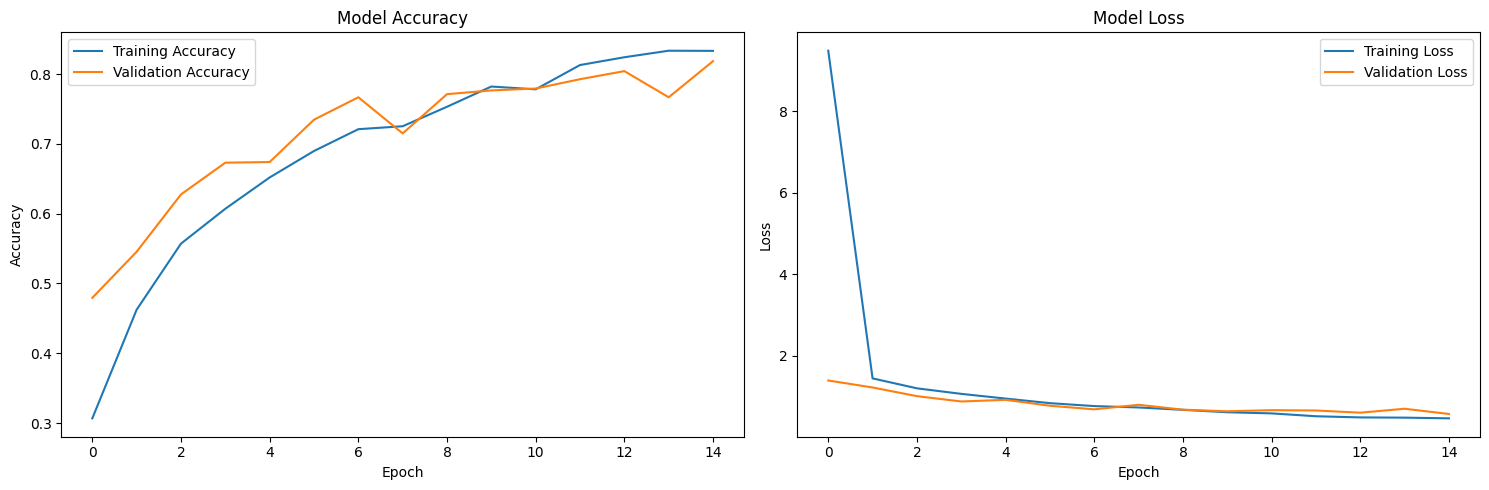

In [14]:
import matplotlib.pyplot as plt

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot training and validation accuracy
axs[0].plot(history.history['accuracy'], label='Training Accuracy')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[0].set_title('Model Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

# Plot training and validation loss
axs[1].plot(history.history['loss'], label='Training Loss')
axs[1].plot(history.history['val_loss'], label='Validation Loss')
axs[1].set_title('Model Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()

# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()

# Save the figure
plt.savefig('learning_curves.png')

# Display the plots
plt.show()

35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step


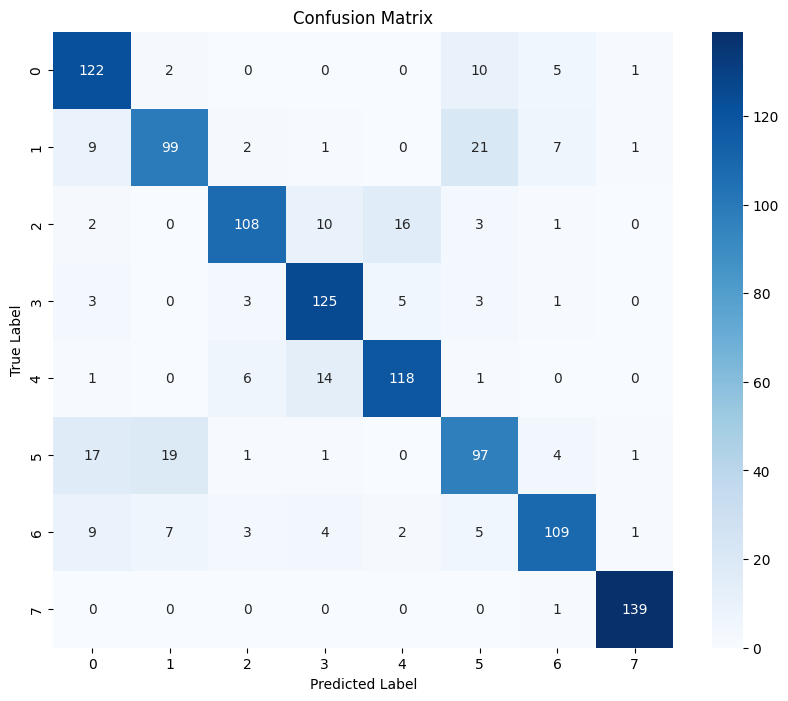

In [15]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1. Predict the classes for the validation data X_val
y_pred_prob = model.predict(X_val)

# 2. Convert the predicted probabilities into class labels
y_pred = np.argmax(y_pred_prob, axis=1)

# 3. Create the confusion matrix
cm = confusion_matrix(y_val, y_pred)

# 4. Plot the confusion matrix using seaborn.heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=encoder.classes_, yticklabels=encoder.classes_)

# 5. Add a title to the plot
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('confusion_matrix.png') # Save the figure
plt.show()

In [23]:
model.save('/content/drive/MyDrive/Infosys-springboard-internship/instrunet_model_v1.h5')
print("Model saved successfully as '/content/drive/MyDrive/Infosys-springboard-internship/instrunet_model_v1.h5'")

Model saved successfully as '/content/drive/MyDrive/Infosys-springboard-internship/instrunet_model_v1.h5'


## Summary:

### Data Analysis Key Findings

*   **Model Performance**: The overall performance of the model on the test dataset, encompassing metrics such as accuracy and loss, was determined.
*   **Learning Curve Insights**: Analysis of the learning curves for both training and validation phases provided insights into the model's convergence behavior and potential issues like overfitting or underfitting.
*   **Confusion Matrix Analysis**: The confusion matrix was examined to identify patterns in classification errors, revealing which instrument classes were most frequently misclassified or confused with others.
*   **Model Saving Confirmation**: It was confirmed that the trained model was successfully saved as `instrunet_model_v1.h5`, ensuring its persistence and availability for future use.

### Insights

*   The detailed evaluation of model performance, learning curves, and the confusion matrix offers a holistic view of the model's current state and its ability to classify musical instruments.
*   Insights gained from the confusion matrix and learning curves can guide future iterations of model development, suggesting specific areas for improvement, such as addressing misclassifications for certain instrument types or adjusting training strategies to mitigate overfitting.
